# Creating a Pipeline of the Best Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
import optuna
import shap

In [2]:
X_resampled = pd.read_csv('X_full.csv')
y_resampled = pd.read_csv('y_full.csv')

In [3]:
# create a function to split the dataset into train, validation and test sets
def data_split(X, y, train_size, val_size, test_size, shuffle = True):
    if shuffle:
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        X = X.iloc[idx].reset_index(drop=True)
        y = y.iloc[idx].reset_index(drop=True)

    # check the portion sizes
    if (train_size + val_size + test_size) != 1:
        portion_size = train_size + val_size + test_size * 100
        # normalize portion sizes
        train_size = train_size/ portion_size
        val_size = val_size/ portion_size
        test_size = test_size/ portion_size

    # split data
    split_data = []
    start = 0
    for size in [train_size, val_size, test_size]:
        end = start + int(size * len(X))
        split_data.append((X.iloc[start:end], y.iloc[start:end]))
        start = end
    return split_data

In [4]:
# Use the defined function to split the data into test, train, and validation
train, val, test = data_split(X_resampled, y_resampled, 0.6, 0.2, 0.2)

# Further split the data into X and y train, test, and validation
train_X, train_y = train
val_X, val_y = val
test_X, test_y = test
train_y = train_y.to_numpy().ravel()
val_y = val_y.to_numpy().ravel()
test_y = test_y.to_numpy().ravel()

# show shape of all the data
print("train_X shape:", train_X.shape)
print("train_y shape:", train_y.shape)
print("val_X shape:", val_X.shape)
print("val_y shape:", val_y.shape)
print("test_X shape:", test_X.shape)
print("test_y shape:", test_y.shape)

train_X shape: (176, 22)
train_y shape: (176,)
val_X shape: (58, 22)
val_y shape: (58,)
test_X shape: (58, 22)
test_y shape: (58,)


In [5]:
train_X

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,120.289,128.143,100.209,0.00492,0.00004,0.00269,0.00238,0.00808,0.01412,0.125,...,0.01194,0.02110,0.01610,23.949,0.467160,0.724045,-6.135296,0.203630,2.539724,0.169923
1,170.368,268.796,79.543,0.00571,0.00003,0.00232,0.00269,0.00696,0.03273,0.281,...,0.02824,0.05139,0.02485,18.540,0.677131,0.685057,-4.796845,0.397749,2.963799,0.277227
2,124.445,135.069,117.495,0.00431,0.00003,0.00141,0.00167,0.00422,0.02184,0.197,...,0.01685,0.03724,0.00479,25.135,0.553134,0.775933,-6.650471,0.254498,1.840198,0.103561
3,228.969,239.541,113.201,0.00238,0.00001,0.00136,0.00140,0.00408,0.01745,0.154,...,0.01234,0.02827,0.00420,24.547,0.305429,0.681811,-7.314237,0.006274,2.118596,0.091546
4,197.569,217.627,90.794,0.00803,0.00004,0.00490,0.00448,0.01470,0.02177,0.189,...,0.01439,0.03836,0.01337,19.269,0.372222,0.725216,-5.736781,0.164529,2.882450,0.202879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,178.222,202.450,141.047,0.00321,0.00002,0.00163,0.00194,0.00488,0.03759,0.327,...,0.02784,0.06219,0.03151,15.924,0.598714,0.712199,-6.366916,0.335753,2.654271,0.144614
172,115.380,123.109,108.634,0.00332,0.00003,0.00160,0.00199,0.00480,0.01503,0.137,...,0.01133,0.02436,0.00401,26.005,0.405991,0.761255,-5.966779,0.197938,1.974857,0.184067
173,180.198,201.249,175.456,0.00284,0.00002,0.00153,0.00166,0.00459,0.01444,0.131,...,0.01190,0.02177,0.00231,26.738,0.403884,0.766209,-6.452058,0.212294,2.269398,0.141929
174,152.845,163.305,75.836,0.00294,0.00002,0.00121,0.00149,0.00364,0.01828,0.158,...,0.01246,0.03191,0.00609,24.922,0.474791,0.654027,-6.105098,0.203653,2.125618,0.170100


## PowerTransformer - PCA - DecisionTree

In [6]:
def objective(trial):
    # PowerTransformer
    pt_method = trial.suggest_categorical('pt_method', ['yeo-johnson'])
    pt = PowerTransformer(method=pt_method)

    # PCA
    pca_n_components = trial.suggest_int('pca_n_components', 1, train_X.shape[1], log=False)
    pca = PCA(n_components=pca_n_components)

    # Decision Tree
    dt_max_depth = trial.suggest_int('dt_max_depth', 1, 23, log=False)
    dt_max_feats = trial.suggest_int('dt_max_feats', 1, 23, log=False)
    dt = DecisionTreeClassifier(max_depth=dt_max_depth)
#    params = {
#        'max_depth': trial.suggest_int('max_depth', 1, 32),
#        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
#        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
#        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
#        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 32),
#        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
#    }
#    dt = DecisionTreeClassifier(**params)


    # Create the pipeline
    pipeline = Pipeline([
        ('power_transformer', pt),
        ('pca', pca),
        ('classifier', dt)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(train_X, train_y)

    # Evaluate the pipeline on the validation set
    y_pred_val = pipeline.predict(val_X)
    accuracy_val = accuracy_score(val_y, y_pred_val)

    return 1.0 - accuracy_val

# Create and run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

#dt_params = {
#    'max_depth': best_params['max_depth'],
#    'min_samples_split': best_params['min_samples_split'],
#    'min_samples_leaf': best_params['min_samples_leaf'],
#    'max_features': best_params['max_features'],
#    'max_leaf_nodes': best_params['max_leaf_nodes'],
#    'criterion': best_params['criterion']
#}

# Train the best pipeline on the entire training set
best_pipeline = Pipeline([
    ('power_transformer', PowerTransformer(method=best_params['pt_method'])),
    ('pca', PCA(n_components=best_params['pca_n_components'])),
    ('classifier', DecisionTreeClassifier(max_depth=best_params['dt_max_depth'], max_features=best_params['dt_max_feats']))
#    ('classifier', DecisionTreeClassifier(**dt_params))
])
best_pipeline.fit(train_X, train_y)

# Evaluate the best pipeline on the test set
y_pred_test = best_pipeline.predict(test_X)
accuracy_test = accuracy_score(test_y, y_pred_test)
print(f"Pipeline Accuracy on Test Set: {accuracy_test}")

[I 2023-12-05 23:55:42,295] A new study created in memory with name: no-name-30720814-109b-4918-8ec5-a505ee3d91c8
[I 2023-12-05 23:55:42,357] Trial 0 finished with value: 0.15517241379310343 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 10, 'dt_max_depth': 15, 'dt_max_feats': 23}. Best is trial 0 with value: 0.15517241379310343.
[I 2023-12-05 23:55:42,433] Trial 1 finished with value: 0.15517241379310343 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 15, 'dt_max_depth': 4, 'dt_max_feats': 13}. Best is trial 0 with value: 0.15517241379310343.
[I 2023-12-05 23:55:42,500] Trial 2 finished with value: 0.22413793103448276 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 22, 'dt_max_depth': 2, 'dt_max_feats': 17}. Best is trial 0 with value: 0.15517241379310343.
[I 2023-12-05 23:55:42,573] Trial 3 finished with value: 0.15517241379310343 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 16, 'dt_max_depth': 17, 'dt_max_feats'

[I 2023-12-05 23:55:45,262] Trial 35 finished with value: 0.13793103448275867 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 17, 'dt_max_depth': 20, 'dt_max_feats': 14}. Best is trial 9 with value: 0.13793103448275867.
[I 2023-12-05 23:55:45,343] Trial 36 finished with value: 0.13793103448275867 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 19, 'dt_max_depth': 10, 'dt_max_feats': 22}. Best is trial 9 with value: 0.13793103448275867.
[I 2023-12-05 23:55:45,421] Trial 37 finished with value: 0.1724137931034483 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 16, 'dt_max_depth': 18, 'dt_max_feats': 18}. Best is trial 9 with value: 0.13793103448275867.
[I 2023-12-05 23:55:45,517] Trial 38 finished with value: 0.12068965517241381 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 21, 'dt_max_depth': 22, 'dt_max_feats': 20}. Best is trial 38 with value: 0.12068965517241381.
[I 2023-12-05 23:55:45,601] Trial 39 finished with v

Pipeline Accuracy on Test Set: 0.8620689655172413


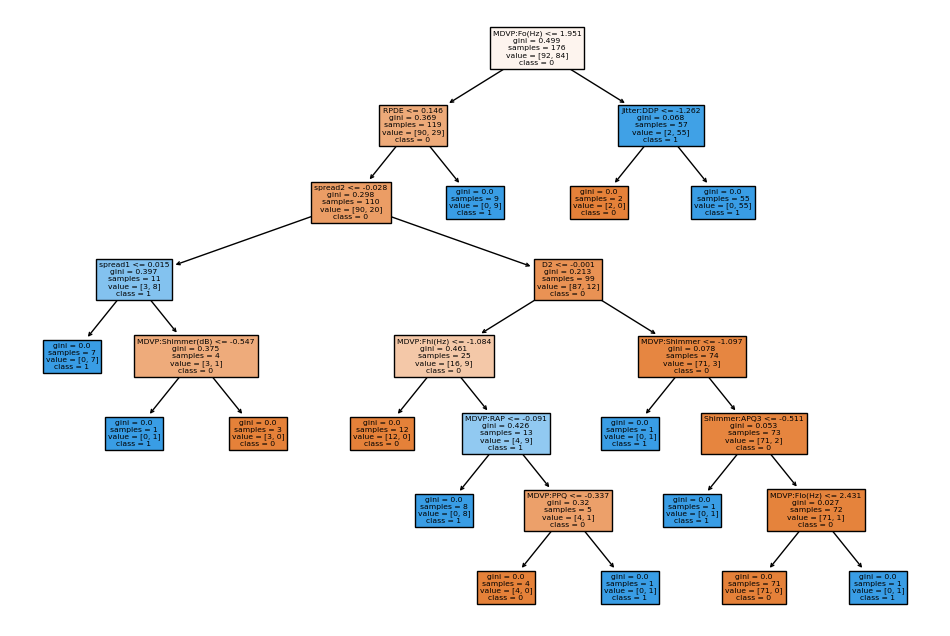

In [7]:
# Extract the trained DecisionTreeClassifier
dt_classifier = best_pipeline.named_steps['classifier']

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_classifier, filled=True, feature_names=list(train_X.columns), class_names=[str(class_label) for class_label in dt_classifier.classes_])
plt.show()

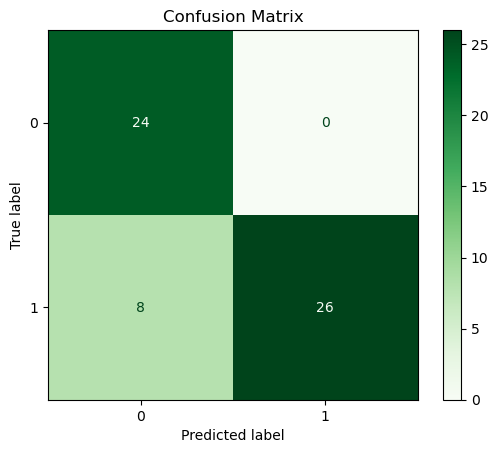

In [8]:
# Compute confusion matrix
cm = confusion_matrix(test_y, y_pred_test)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline.classes_)
disp.plot(cmap='Greens') 
plt.title('Confusion Matrix')
plt.show()

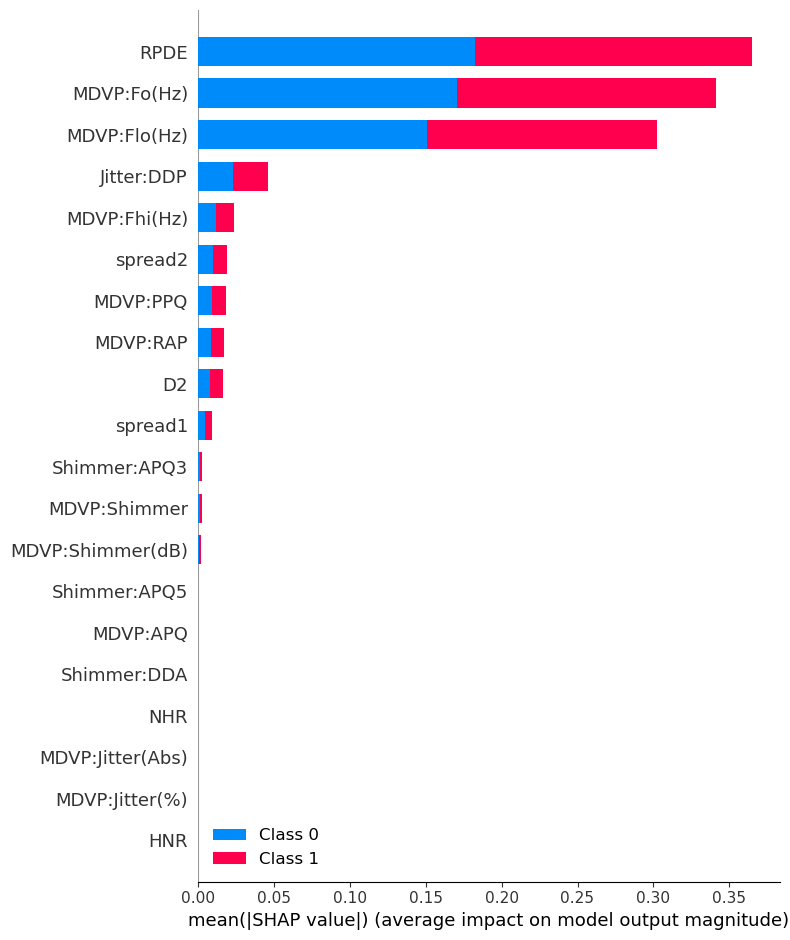

In [9]:
# Using the tree based explainer
explainer = shap.TreeExplainer(best_pipeline.named_steps['classifier'])

# Generate SHAP values for a set of samples 
shap_values = explainer.shap_values(val_X)

# Summary plot
shap.summary_plot(shap_values, val_X)

## RobustScaler - PCA - Decision Tree

In [10]:
def objective(trial):
    # PCA
    pca_n_components = trial.suggest_int('pca_n_components', 1, train_X.shape[1], log=False)
    pca = PCA(n_components=pca_n_components)

    # Decision Tree
    dt_max_depth = trial.suggest_int('dt_max_depth', 1, 23, log=False)
    dt_max_feats = trial.suggest_int('dt_max_feats', 1, 23, log=False)
    dt = DecisionTreeClassifier(max_depth=dt_max_depth)
#    params = {
#        'max_depth': trial.suggest_int('max_depth', 1, 32),
#        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
#        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
#        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
#        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 32),
#        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
#    }
#    dt = DecisionTreeClassifier(**params)

    # Create the pipeline
    pipeline = Pipeline([
        ('robust_scaler', RobustScaler()),
        ('pca', pca),
        ('classifier', dt)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(train_X, train_y)

    # Evaluate the pipeline on the validation set
    y_pred_val = pipeline.predict(val_X)
    accuracy_val = accuracy_score(val_y, y_pred_val)

    return 1.0 - accuracy_val

# Create and run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
# Extract hyperparameters for DecisionTreeClassifier

#dt_params = {
#    'max_depth': best_params['max_depth'],
#    'min_samples_split': best_params['min_samples_split'],
#    'min_samples_leaf': best_params['min_samples_leaf'],
#    'max_features': best_params['max_features'],
#    'max_leaf_nodes': best_params['max_leaf_nodes'],
#    'criterion': best_params['criterion']
#}

# Train the best pipeline on the entire training set
best_pipeline = Pipeline([
    ('robust_scaler', RobustScaler()),
    ('pca', PCA(n_components=best_params['pca_n_components'])),
    ('classifier', DecisionTreeClassifier(max_depth=best_params['dt_max_depth'],max_features=best_params['dt_max_feats']))
#    ('classifier', DecisionTreeClassifier(**dt_params))
])
best_pipeline.fit(train_X, train_y)

# Evaluate the best pipeline on the test set
y_pred_test = best_pipeline.predict(test_X)
accuracy_test = accuracy_score(test_y, y_pred_test)
print(f"Pipeline Accuracy on Test Set: {accuracy_test}")

[I 2023-12-05 23:55:47,922] A new study created in memory with name: no-name-e82695f2-cc2a-415f-b7f2-e95ddc567698
[I 2023-12-05 23:55:47,941] Trial 0 finished with value: 0.06896551724137934 and parameters: {'pca_n_components': 8, 'dt_max_depth': 7, 'dt_max_feats': 15}. Best is trial 0 with value: 0.06896551724137934.
[I 2023-12-05 23:55:47,956] Trial 1 finished with value: 0.27586206896551724 and parameters: {'pca_n_components': 1, 'dt_max_depth': 2, 'dt_max_feats': 11}. Best is trial 0 with value: 0.06896551724137934.
[I 2023-12-05 23:55:47,971] Trial 2 finished with value: 0.18965517241379315 and parameters: {'pca_n_components': 2, 'dt_max_depth': 15, 'dt_max_feats': 12}. Best is trial 0 with value: 0.06896551724137934.
[I 2023-12-05 23:55:47,991] Trial 3 finished with value: 0.1724137931034483 and parameters: {'pca_n_components': 1, 'dt_max_depth': 11, 'dt_max_feats': 23}. Best is trial 0 with value: 0.06896551724137934.
[I 2023-12-05 23:55:48,006] Trial 4 finished with value: 0.24

[I 2023-12-05 23:55:49,141] Trial 39 finished with value: 0.06896551724137934 and parameters: {'pca_n_components': 8, 'dt_max_depth': 9, 'dt_max_feats': 12}. Best is trial 0 with value: 0.06896551724137934.
[I 2023-12-05 23:55:49,178] Trial 40 finished with value: 0.10344827586206895 and parameters: {'pca_n_components': 8, 'dt_max_depth': 17, 'dt_max_feats': 7}. Best is trial 0 with value: 0.06896551724137934.
[I 2023-12-05 23:55:49,209] Trial 41 finished with value: 0.10344827586206895 and parameters: {'pca_n_components': 6, 'dt_max_depth': 9, 'dt_max_feats': 11}. Best is trial 0 with value: 0.06896551724137934.
[I 2023-12-05 23:55:49,244] Trial 42 finished with value: 0.08620689655172409 and parameters: {'pca_n_components': 9, 'dt_max_depth': 7, 'dt_max_feats': 13}. Best is trial 0 with value: 0.06896551724137934.
[I 2023-12-05 23:55:49,274] Trial 43 finished with value: 0.12068965517241381 and parameters: {'pca_n_components': 10, 'dt_max_depth': 6, 'dt_max_feats': 11}. Best is trial

Pipeline Accuracy on Test Set: 0.8620689655172413


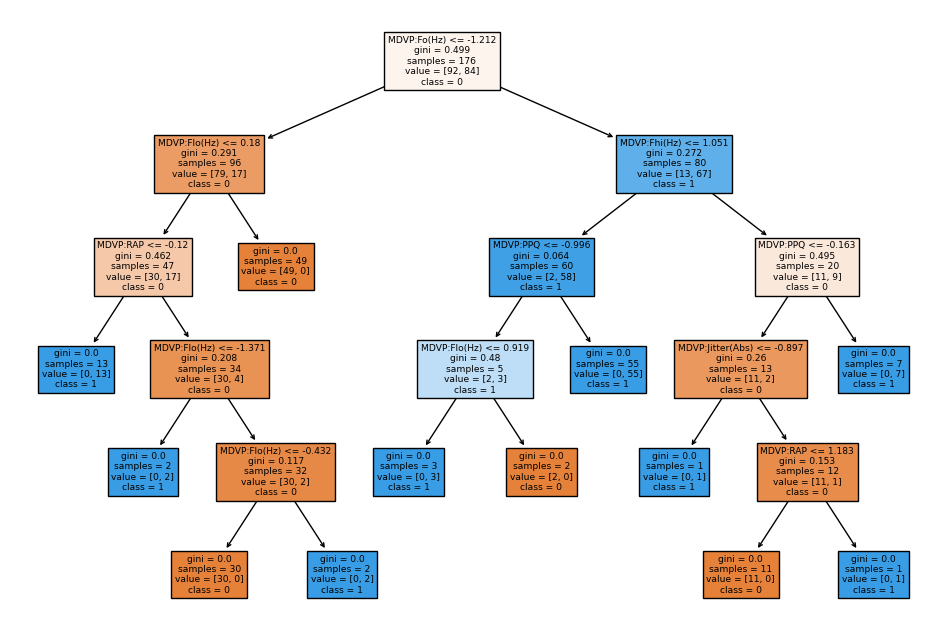

In [11]:
# Extract the trained DecisionTreeClassifier
dt_classifier = best_pipeline.named_steps['classifier']

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_classifier, filled=True, feature_names=list(train_X.columns), class_names=[str(class_label) for class_label in dt_classifier.classes_])
plt.show()

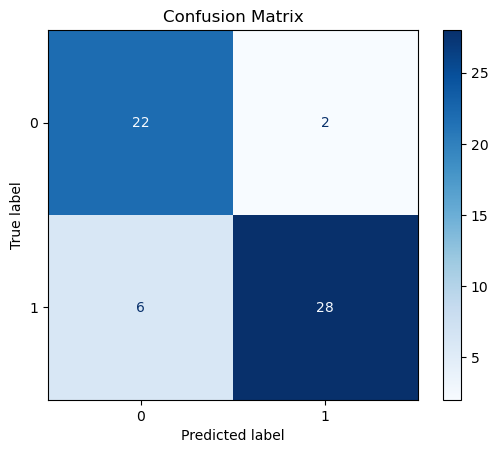

In [12]:
# Compute confusion matrix
cm = confusion_matrix(test_y, y_pred_test)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline.classes_)
disp.plot(cmap='Blues') 
plt.title('Confusion Matrix')
plt.show()

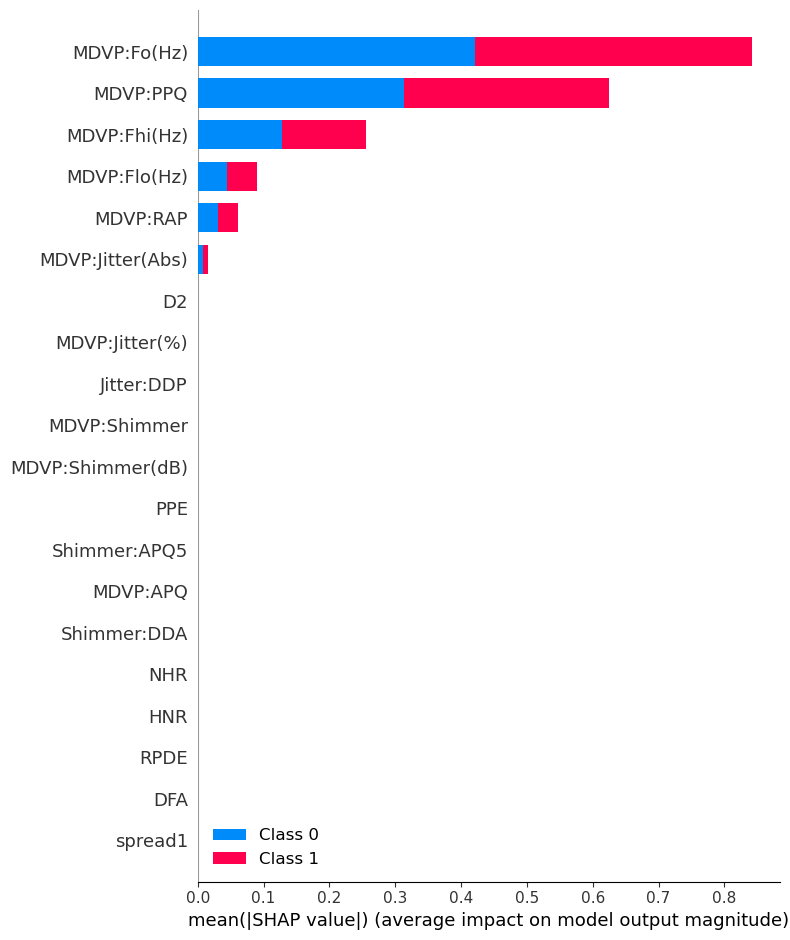

In [13]:
# Using the tree based explainer
explainer = shap.TreeExplainer(best_pipeline.named_steps['classifier'])

# Generate SHAP values for a set of samples 
shap_values = explainer.shap_values(val_X)

# Summary plot
shap.summary_plot(shap_values, val_X)